In [32]:
import eli5
import argparse
import pickle
from math import log
from typing import Dict, Any, Callable, Union, NamedTuple, Optional, List
from collections import Counter

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
import pandas as pd

from reader.data import load_corpus, Corpus, Sentence, Token
from reader.scoring import Score, score_corpus

labels = ['Cannot-decide', 'Left-leaning', 'Right-leaning']


In [23]:
def train_logistic_regression(train, test, c_value, solver, feature_func):
    exp_header = ["c", "solver", "feature_func"]

    first_row = True
    row = [str(c_value), solver, feature_func.__name__]
    model = MLModel(
        LogisticRegression(C=c_value, solver=solver,
                           multi_class="multinomial", penalty="l2", max_iter=10000), feature_func
    )
    features = model.train(train)

    pred_corpus = model.predict(test)
    score = score_corpus(test, pred_corpus)
    if first_row:
        print(",".join(exp_header + score.header()))
        first_row = False
    print(",".join(row + score.row()))
    return model


# can also change here to decide use ngrams features or not
def get_feature_names(instance: Sentence, 
                      use_unigrams: bool = True, 
                      use_bigrams: bool = True, 
                      use_trigrams: bool = True) -> List[str]:
    ngrams = []
    unigrams = [token.text.lower() for token in instance.tokens]
    if use_unigrams:
        ngrams.extend(unigrams)
    if use_bigrams:
        bigrams = ["_".join(pair) for pair in zip(unigrams[:-1], unigrams[1:])]
        ngrams.extend(bigrams)
    if use_trigrams:
        trigrams = ["_".join(pair) for pair in zip(unigrams[:-2], unigrams[1:-1], unigrams[2:])]
        ngrams.extend(trigrams)
    return ngrams


def binary_bow(instance: Sentence) -> Dict[str, float]:
    features = get_feature_names(instance)
    return {feat: 1.0 for feat in features}


def count_bow(instance: Sentence) -> Dict[str, float]:
    features = get_feature_names(instance)
    return {
        token: float(count)
        for token, count in Counter(
            features
        ).items()
    }


def log_count_bow(instance: Sentence) -> Dict[str, float]:
    return {token: log(count) for token, count in count_bow(instance).items()}


def _token_str(token: Token) -> str:
    return token.text.lower()

In [24]:
class MLModel:
    def __init__(self, model, feature_function,) -> None:
        self.feature_func = feature_function
        self.vectorizer = DictVectorizer()
        self.model = model

    def train(self, corpus: Corpus) -> None:
        features = self.vectorizer.fit_transform(
            self.feature_func(instance) for instance in corpus
        )
        labels = tuple(corpus.stances)
        self.model.fit(features, labels)

    def predict(self, corpus: Corpus) -> Corpus:
        features = self.vectorizer.transform(
            self.feature_func(instance) for instance in corpus
        )
        preds = self.model.predict(features)
        return Corpus(
            tuple(
                instance.copy_with_stance(pred) for instance, pred in zip(corpus, preds)
            )
        )

In [25]:
# ===== parameters =====
train_path = "data/gold-split/train_unsampled/combined.csv"
test_path = "data/gold-split/test/combined.csv"
c_value = 0.05
solver = 'saga'
feature_func = binary_bow
bias = False
use_moral_dict = True
# ===== parameters =====

if use_moral_dict:
    with open("data/additional_resources/moral_dict.pkl", "rb") as f:
        moral_dict_mapping = pickle.load(f)
else:
    moral_dict_mapping = None

train_corpus = load_corpus(train_path, bias, moral_dict_mapping)
test_corpus = load_corpus(test_path, bias, moral_dict_mapping)
model = train_logistic_regression(train_corpus, test_corpus, c_value, solver, feature_func)

c,solver,feature_func,micro_f,macro_f,acc,supp,Cannot-decide_prec,Cannot-decide_rec,Cannot-decide_f,Cannot-decide_supp,Left-leaning_prec,Left-leaning_rec,Left-leaning_f,Left-leaning_supp,Right-leaning_prec,Right-leaning_rec,Right-leaning_f,Right-leaning_supp
0.05,saga,binary_bow,58.63,50.57,58.63,1182,43.69,18.00,25.50,250,61.68,55.98,58.69,368,59.33,78.37,67.53,564


In [26]:
pred_corpus = model.predict(test_corpus)

In [35]:
def result2csv(test_corpus, pred_corpus):
    correct_lst = []
    wrong_lst = []
    for i, (gold_snt, pred_snt) in enumerate(zip(test_corpus, pred_corpus)):
        gold_str = " ".join(gold_snt.token_strs)
        gold_stance = gold_snt.stance
        pred_stnace = pred_snt.stance
        if gold_stance == pred_stnace:
            correct_lst.append([i, gold_str, gold_stance, pred_stnace])
        else:
            wrong_lst.append([i, gold_str, gold_stance, pred_stnace])
    pd.DataFrame(correct_lst, columns="snt_idx snt gold pred".split()).to_csv("logre_corr.csv", index=False)
    pd.DataFrame(wrong_lst, columns="snt_idx snt gold pred".split()).to_csv("logre_wron.csv", index=False)

    
result2csv(test_corpus, pred_corpus)

In [7]:
eli5.show_weights(model.model,
                  feature_names=model.vectorizer.get_feature_names(),
                  target_names=labels, top=50)

In [46]:
idx = 316
example_sent = " ".join(test_corpus[idx].token_strs)
print(f"- Sentence: {example_sent}\n")
print('- Gold label: ',  test_corpus[idx].stance)
print('- Predicted label: ',  pred_corpus[idx].stance)

eli5.show_prediction(model.model, binary_bow(test_corpus[idx]), vec=model.vectorizer,
                     target_names=labels, top=30)

- Sentence: President Pete has a ring to it.

- Gold label:  Left-leaning
- Predicted label:  Left-leaning


In [60]:
from nltk.metrics import ConfusionMatrix
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd

In [61]:
preds = list(model.predict(test_corpus).stances)
golds = list(test_corpus.stances)

In [62]:
cm = ConfusionMatrix(golds, preds)

In [63]:
cm_counts = []

for gold in labels:
    tmp = []
    for pred in labels:
        tmp.append(cm[gold, pred])
    cm_counts.append(tmp)
cm_counts
counts_df = pd.DataFrame(cm_counts, columns=["CD", "LL", "RL"], index=["CD", "LL", "RL"])

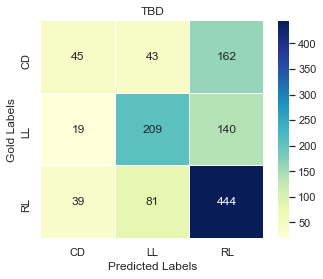

In [77]:
f, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(counts_df, linewidth=0.1, ax=ax, cmap='YlGnBu', annot=True, fmt="d")
plt.title("TBD")
plt.xlabel('Predicted Labels')
plt.ylabel('Gold Labels')
plt.savefig('cm.png', dpi=200)